# Example creating aligned hierarchies for a Mazurka Score

In this example, we will walk through the elements of the `ah` package that pertain to the creation of aligned hierarchies for a music-based data stream (like a song).

Beginning with features (such as MFCCs or chroma features) for each timestep in your music based data stream, there are several steps to this process:

0. Create the self-dissimilarity matrix (SDM)
1. Highlight pairs of timesteps deemed close enough to be considered as repetitions of each other. (In other words, threshold the SDM)
2. Find pairs of structure repetitions (represented as diagonals within the thresholded SDM)
3. Find any pairs of structure repetitions not found in the previous step; and group the structure repetitions
4. Remove and repeated structures that have any instances that overlap
5. Distill the collection of repeated structures into the _essential structure components_, i.e. the smallest meaningful repetitions on which all larger repeats are constructed. Each timestep will be contained in no more than one essential structure component

_Note_: This python notebook borrows heavily from `example.py` found in this directory. 


An example function pipeline is shown below to illustrate the function calls of each step. For an in depth look at each function, see the corresponsing jupyter notebooks for each module. 
- Yellow: utilities
- Purple: search
- Green: transform
- Red: assemble 

![alt text](function_flow_steps.png)

We begin by importing the necessary packages: 

In [1]:
#numpy and scipy are required for mathematical operations
import scipy.io as sio
import numpy as np

#utilities imports needed functions
from utilities import *
from search import *
from transform import *
from assemble import *

#matplotlib is used to display outputs
import matplotlib.pyplot as plt

## Step 0: Creating the SDM 

In this phase, there are a few crucial details, namely importing the data file that we would like to unearth hierarchical structural information for and determining the appropriate dissimilarity measure to use. If you already have (symmetrical) matrix representations for your data stream, then you may find it more appropriate to load your matrix and then skip ahead to Step 1 or Step 2. 

This step assumes that your music-based data stream (ie. a recording or score) has already had your preferred features extracted (like chroma or MFCCs) and is arranged into columns such that each column represents a time step (or beat). We refer to this as a _feature vector matrix_ as each feature vector is laid out as column within one cohesive matrix. 

### Importing Data for structure analysis

Here we import the file in a familiar manner:

In [2]:
file_in = "input.csv"

with open(file_in, 'r', newline='\n') as f:
    fv_mat = np.loadtxt(f, delimiter = ',')

### Creating the SDM

In just one line, we define the self-dissimiliarity matrix. This function `create_sdm`

[[0.         0.28813862 0.51259504 ... 0.7575822  0.81139542 0.81133335]
 [0.28813862 0.         0.26375769 ... 0.56254648 0.89303436 0.85019882]
 [0.51259504 0.26375769 0.         ... 0.42258308 0.64702668 0.8048716 ]
 ...
 [0.7575822  0.56254648 0.42258308 ... 0.         0.38009303 1.        ]
 [0.81139542 0.89303436 0.64702668 ... 0.38009303 0.         0.81572885]
 [0.81133335 0.85019882 0.8048716  ... 1.         0.81572885 0.        ]]


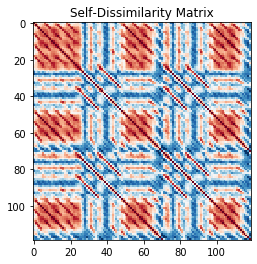

In [6]:
#number of feature vectors per shingle
num_fv_per_shingle = 3

#creates the self-dissimilarity matrix
self_dissim_mat = create_sdm(fv_mat, num_fv_per_shingle)

print(self_dissim_mat)

#produces a visualization
SDM = plt.imshow(self_dissim_mat, cmap="RdBu")
plt.title('Self-Dissimilarity Matrix')
plt.show()


## Step 1: Thresholding the SDM 

In this step, the self-dissimilarity matrix is threshholded to produce a binary matrix of the same dimensions. This matrix is used to identify repeated structures, which are represented by diagonals of the same length. 

[[ True False False ... False False False]
 [False  True False ... False False False]
 [False False  True ... False False False]
 ...
 [False False False ...  True False False]
 [False False False ... False  True False]
 [False False False ... False False  True]]


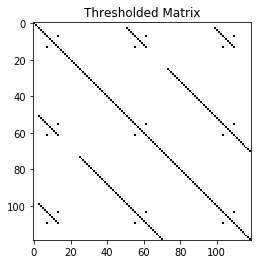

In [7]:
song_length = self_dissim_mat.shape[0]
thresh = 0.01

#thresholds the SDM to produce a binary matrix 
thresh_dist_mat = (self_dissim_mat <= thresh) 

print(thresh_dist_mat)

#produces a visualization
SDM = plt.imshow(thresh_dist_mat, cmap="Greys")
plt.title('Thresholded Matrix')
plt.show()

## Step 2: Find the diagonals present in T and store all found pairs of repeats in the list L

The diagonals in the thresholded matrix are found and recorded in an array of repeats.

Find initial repeats 

In [8]:
all_lst = find_initial_repeats(thresh_dist_mat, np.arange(1,song_length+1), 0)
    
print(all_lst)

[[  8   8  14  14   1]
 [ 14  14  56  56   1]
 [  8   8  62  62   1]
 [ 56  56  62  62   1]
 [ 14  14 104 104   1]
 [ 62  62 104 104   1]
 [  8   8 110 110   1]
 [ 56  56 110 110   1]
 [104 104 110 110   1]
 [  4  14  52  62  11]
 [  4  14 100 110  11]
 [ 26  71  74 119  46]
 [  1 119   1 119 119]]


## Step 3: Find any diagonals in T not found in step 2 contained in larger diagonals in T, then group pairs of repeats

Any diagonals that are contained in larger diagonals are found and added to the array of repeats

In [9]:
complete_lst = find_complete_list(all_lst, song_length)
    
print('complete_lst:',complete_lst)

complete_lst: [[  8   8  14  14   1   1]
 [  8   8  56  56   1   1]
 [  8   8  62  62   1   1]
 [  8   8 104 104   1   1]
 [  8   8 110 110   1   1]
 [ 14  14  56  56   1   1]
 [ 14  14  62  62   1   1]
 [ 14  14 104 104   1   1]
 [ 14  14 110 110   1   1]
 [ 56  56  62  62   1   1]
 [ 56  56 104 104   1   1]
 [ 56  56 110 110   1   1]
 [ 62  62 104 104   1   1]
 [ 62  62 110 110   1   1]
 [104 104 110 110   1   1]
 [  4   7  52  55   4   1]
 [  4   7 100 103   4   1]
 [  9  14  57  62   6   1]
 [  9  14 105 110   6   1]
 [ 63  71 111 119   9   1]
 [  4  13  52  61  10   1]
 [  4  13 100 109  10   1]
 [  4  14  52  62  11   1]
 [  4  14 100 110  11   1]
 [ 52  62 100 110  11   1]
 [ 57  71 105 119  15   1]
 [ 26  51  74  99  26   1]
 [ 26  55  74 103  30   1]
 [ 26  61  74 109  36   1]
 [ 26  71  74 119  46   1]]


## Step 4: Remove any repeated structure that have at least two repeats that overlap

In this step, repeated structures with the same annotation and length are removed if they are overlapping.


In [10]:
output_tuple = remove_overlaps(complete_lst, song_length)
        
print(output_tuple)

(array([[  8,   8,  14,  14,   1,   1],
       [  8,   8,  56,  56,   1,   1],
       [  8,   8,  62,  62,   1,   1],
       [  8,   8, 104, 104,   1,   1],
       [  8,   8, 110, 110,   1,   1],
       [ 14,  14,  56,  56,   1,   1],
       [ 14,  14,  62,  62,   1,   1],
       [ 14,  14, 104, 104,   1,   1],
       [ 14,  14, 110, 110,   1,   1],
       [ 56,  56,  62,  62,   1,   1],
       [ 56,  56, 104, 104,   1,   1],
       [ 56,  56, 110, 110,   1,   1],
       [ 62,  62, 104, 104,   1,   1],
       [ 62,  62, 110, 110,   1,   1],
       [104, 104, 110, 110,   1,   1],
       [  4,   7,  52,  55,   4,   1],
       [  4,   7, 100, 103,   4,   1],
       [  9,  14,  57,  62,   6,   1],
       [  9,  14, 105, 110,   6,   1],
       [ 63,  71, 111, 119,   9,   1],
       [  4,  13,  52,  61,  10,   1],
       [  4,  13, 100, 109,  10,   1],
       [  4,  14,  52,  62,  11,   1],
       [  4,  14, 100, 110,  11,   1],
       [ 52,  62, 100, 110,  11,   1],
       [ 57,  71, 105, 1

## Step 5: Find the essential structure components of the song represented by D

The essential structure components of the song are found.

## Step 6: Build the aligned hierarchies 

Finally, the aligned hierarchies are built using the essential structure components.